# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import eli5

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import nltk

nltk.download('stopwords')

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [ ]:
raw_df = pd.read_csv('./data/tweet_sentiment_train.csv.zip')
raw_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
raw_df[raw_df['text'].isna()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [ ]:
raw_df.dropna(inplace=True, ignore_index=True)

In [ ]:
raw_df.shape

(27480, 4)

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [ ]:
(raw_df['sentiment'].value_counts() / raw_df.shape[0] * 100).round(2)

sentiment
neutral     40.45
positive    31.23
negative    28.32
Name: count, dtype: float64

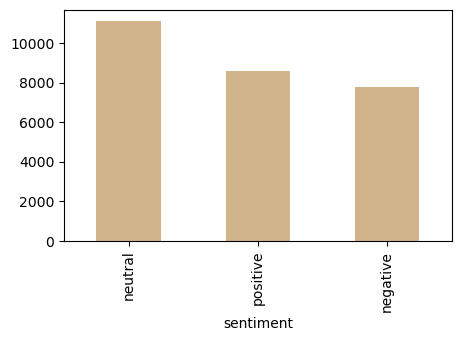

In [ ]:
plt.figure(figsize=(5, 3))
raw_df['sentiment'].value_counts().plot(kind='bar', color='tan')
plt.show()

Our dataset contains three class labels: `neutral` - the largest class (40%), followed by `positive` (31%) and `negative` (28%).

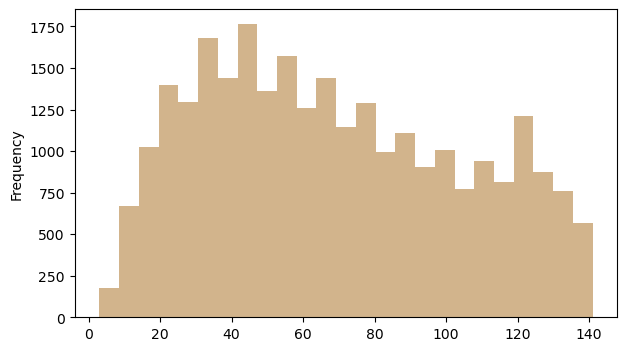

In [ ]:
plt.figure(figsize=(7, 4))
raw_df['text'].str.len().plot.hist(bins=25, color='tan')
plt.show()

In [ ]:
raw_df['text'].str.len().max()

141

Most posts have a length in the range of 40-50 characters. The distribution is slightly skewed to the right with the maximum length is 141, which suggest that longer posts might be dropped.

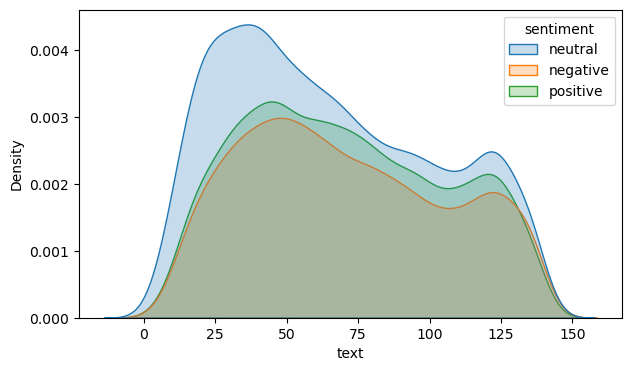

In [ ]:
plt.figure(figsize=(7, 4))
sns.kdeplot(x=raw_df['text'].str.len(),
            hue=raw_df['sentiment'], fill=True)
plt.show()

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [ ]:
stemmer = SnowballStemmer(language='english')
english_stopwords = stopwords.words('english')


def tokenize(text):
    return [stemmer.stem(word) for word in word_tokenize(text)
            if word.lower() not in english_stopwords]


vectorizer = CountVectorizer(
    tokenizer=tokenize,
    stop_words='english',
    max_features=1500
)

vectorizer.fit(raw_df.text)
len(vectorizer.vocabulary_)

d:\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
 

1500

In [ ]:
vectorizer.get_feature_names_out()[:150]

array(['!', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '--',
       '.', '..', '...', '....', '.....', '......', '.......', '........',
       '/', '1', '10', '100', '11', '12', '13', '14', '15', '17', '18',
       '1st', '2', '20', '200', '21', '24', '25', '2day', '2nd', '2nite',
       '3', '30', '3d', '3rd', '4', '40', '4th', '5', '50', '6', '7', '8',
       '80', '9', ':', ';', '<', '=', '>', '?', '@', '[', ']', '_', '`',
       'abl', 'absolut', 'abt', 'accept', 'access', 'accid', 'account',
       'ace', 'ach', 'act', 'action', 'activ', 'actual', 'ad', 'add',
       'addict', 'admit', 'ador', 'advic', 'afford', 'afraid',
       'afternoon', 'age', 'ago', 'agre', 'ah', 'aha', 'ahead', 'ahh',
       'ahhh', 'ahhhh', 'aim', 'aint', 'air', 'airport', 'alarm', 'album',
       'alex', 'allergi', 'allow', 'alon', 'alot', 'alreadi', 'alright',
       'alway', 'amaz', 'america', 'american', 'angel', 'anim', 'announc',
       'annoy', 'anoth', 'answer', 'anybodi', 'anymor', 'an

In [ ]:
vectorizer.get_feature_names_out()[300:400]

array(['check', 'cheer', 'chees', 'chicago', 'chick', 'chicken',
       'children', 'chill', 'chillin', 'chines', 'chip', 'chocol',
       'choic', 'choos', 'chris', 'christian', 'church', 'citi', 'class',
       'clean', 'clear', 'click', 'client', 'close', 'cloth', 'cloud',
       'cloudi', 'club', 'cnt', 'coast', 'code', 'coffe', 'cold',
       'collect', 'colleg', 'color', 'come', 'comment', 'comp', 'compani',
       'complet', 'comput', 'concert', 'confus', 'congrat', 'congratul',
       'connect', 'consid', 'constant', 'contact', 'continu', 'control',
       'convers', 'convinc', 'cook', 'cooki', 'cool', 'copi', 'correct',
       'cos', 'cost', 'cough', 'count', 'countri', 'coupl', 'cours',
       'cousin', 'cover', 'coz', 'crack', 'crappi', 'crash', 'crave',
       'crazi', 'cream', 'creat', 'credit', 'cri', 'cross', 'crush',
       'cup', 'cupcak', 'current', 'cut', 'cute', 'cuz', 'da', 'dad',
       'daddi', 'dammit', 'danc', 'dang', 'dark', 'darn', 'date',
       'daughter', 

In [ ]:
vectorizer.get_feature_names_out()[-100:]

array(['vega', 'version', 'vid', 'video', 'view', 'visit', 'voic', 'vote',
       'w', 'w/', 'w/o', 'wait', 'waitin', 'wake', 'walk', 'wall', 'wan',
       'want', 'war', 'warm', 'wash', 'wasnt', 'wast', 'wat', 'watch',
       'watchin', 'water', 'wave', 'way', 'wear', 'weather', 'web',
       'websit', 'wed', 'wednesday', 'wee', 'week', 'weekend', 'weird',
       'welcom', 'went', 'whatev', 'white', 'wide', 'wife', 'wii', 'wild',
       'win', 'wind', 'window', 'wine', 'winter', 'wish', 'wit', 'woke',
       'wolverin', 'woman', 'women', 'wonder', 'wont', 'woo', 'woot',
       'word', 'work', 'workin', 'world', 'worri', 'wors', 'worst',
       'worth', 'wow', 'wrap', 'write', 'wrong', 'wtf', 'x', 'xd', 'xo',
       'xoxo', 'ya', 'yall', 'yard', 'yay', 'yea', 'yeah', 'year', 'yep',
       'yes', 'yesterday', 'yo', 'york', 'young', 'youtub', 'yr', 'yum',
       'yummi', 'yup', '|', '~', 'ï¿½'], dtype=object)

In [ ]:
inputs = vectorizer.transform(raw_df.text)
inputs.shape

(27480, 1500)

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [ ]:
train_idx, test_idx = train_test_split(
    raw_df.index,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_train_bow, X_test_bow = inputs[train_idx], inputs[test_idx]
y_train, y_test = raw_df.loc[train_idx, 'sentiment'], raw_df.loc[test_idx, 'sentiment']

label_enc = LabelEncoder().fit(y_train)
y_train = label_enc.transform(y_train)
y_test = label_enc.transform(y_test)

print(f"Length of train set: {X_train_bow.shape[0]}")
print(f"Length of test set: {X_test_bow.shape[0]}")

Length of train set: 21984
Length of test set: 5496


In [ ]:
def try_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train,
                             scoring='f1_weighted',
                             cv=3, n_jobs=-1)

    print("f1-score weighted:", scores.mean().round(4))

#### Logistic Regression

In [ ]:
MAX_ITER = 5000

In [ ]:
log_reg = LogisticRegression(max_iter=MAX_ITER, solver='sag', random_state=42)
try_model(log_reg, X_train_bow, y_train)

f1-score weighted: 0.6905


#### OneVsRestClassifier

In [ ]:
log_reg = LogisticRegression(max_iter=MAX_ITER, solver='sag', random_state=42)
ovr_model = OneVsRestClassifier(log_reg)
try_model(ovr_model, X_train_bow, y_train)

f1-score weighted: 0.6921


#### OneVsOneClassifier

In [ ]:
ovo_model = OneVsOneClassifier(log_reg)
try_model(ovo_model, X_train_bow, y_train)

f1-score weighted: 0.6966


#### RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier(max_depth=20, random_state=42)
try_model(rf_model, X_train_bow, y_train)

f1-score weighted: 0.6321


In [ ]:
rf_model = RandomForestClassifier(max_depth=30, random_state=42)
try_model(rf_model, X_train_bow, y_train)

f1-score weighted: 0.6559


In [ ]:
rf_model = RandomForestClassifier(max_depth=40, random_state=42)
try_model(rf_model, X_train_bow, y_train)

f1-score weighted: 0.6684


#### XGBClassiifier

In [ ]:
for max_depth in [5, 7, 10, 12, 15, 17]:
    xgb_model = XGBClassifier(max_depth=max_depth, random_state=42, n_jobs=-1)
    print(f"max_depth = {max_depth}")
    try_model(xgb_model, X_train_bow, y_train)

max_depth = 5
f1-score weighted: 0.6942
max_depth = 7
f1-score weighted: 0.6998
max_depth = 10
f1-score weighted: 0.7009
max_depth = 12
f1-score weighted: 0.7025
max_depth = 15
f1-score weighted: 0.7019
max_depth = 17
f1-score weighted: 0.6996


#### LGBMClassifier

In [ ]:
X_train_int = X_train_bow.astype(np.float32)

In [ ]:
lgb_model = LGBMClassifier(num_leaves=25, random_state=42)
try_model(lgb_model, X_train_int, y_train)

f1-score weighted: 0.7002


In [ ]:
lgb_model = LGBMClassifier(num_leaves=31, random_state=42)
try_model(lgb_model, X_train_int, y_train)

f1-score weighted: 0.7024


In [ ]:
lgb_model = LGBMClassifier(num_leaves=35, random_state=42)
try_model(lgb_model, X_train_int, y_train)

f1-score weighted: 0.702


To compare performance, we used weighted F1-score because we are dealing with an slightly imbalanced multiclass task.

`XGBClassifier` with `max_depth = 12` and `LGBMClassifier` with `num_leaves = 31` show similar results, but `XGBClassifier` performs slightly better.

#### Classification Report

In [ ]:
xgb_model = XGBClassifier(max_depth=12, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_bow, y_train)
y_pred = xgb_model.predict(X_test_bow)

print(classification_report(y_test, y_pred,
                            target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.75      0.58      0.65      1572
     neutral       0.65      0.77      0.71      2236
    positive       0.76      0.75      0.76      1688

    accuracy                           0.71      5496
   macro avg       0.72      0.70      0.71      5496
weighted avg       0.71      0.71      0.71      5496



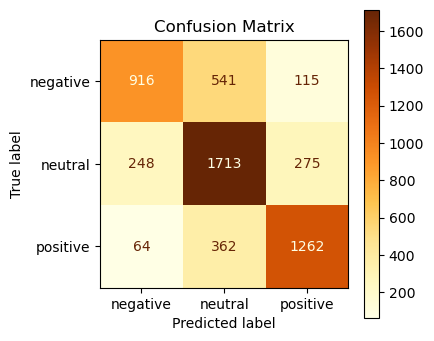

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix")
plt.show()

- A large number of negatives posts are predicted as neutral, indicating the model confuses negative and neutral classes.
- Neutral is slightly over-predicted: High recall (0.77) and lower precision (0.66) indicate it might be misclassifying other classes as neutral. Most neutral samples are correctly classified, but confusion with both other classes exists.
- Positive class is relatively well-predicted (precision and recall are both high and well-balanced), though still confused with neutral class.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [ ]:
feature_importance = pd.Series(
    xgb_model.feature_importances_,
    index=vectorizer.get_feature_names_out(),
    name='importance'
).sort_values(ascending=False)

In [ ]:
feature_importance.index[:20]

Index(['thank', 'happi', 'amaz', 'hurt', 'suck', 'nice', 'sad', 'hate',
       'awesom', 'love', 'fail', 'enjoy', 'ugh', 'great', 'cute', 'bore',
       'sick', 'excit', 'best', 'stupid'],
      dtype='object')

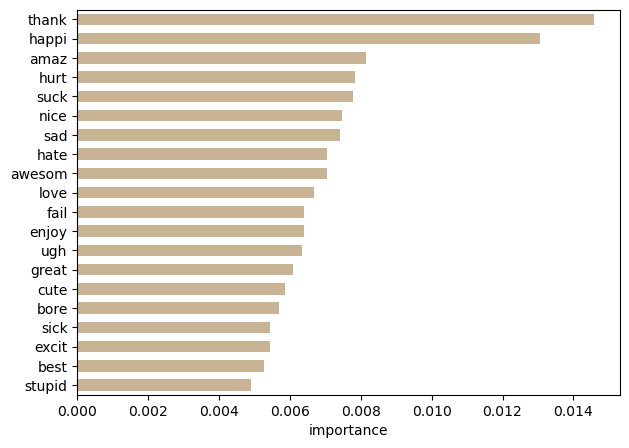

In [ ]:
plt.figure(figsize=(7, 5))
sns.barplot(feature_importance[:20], orient='h', color='tan', width=0.6)
plt.show()

- All these top words are clear indicators of strong sentiment polarity (positive or negative).
- Positive sentiment indicators: "thank", "happi", "amaz", "nice", "awesom", "love", "enjoy", "great", "cute", "excit", "best". These likely contribute heavily to predicting the positive class.
- Negative sentiment indicators: "hurt", "suck", "sad", "hate", "fail", "ugh", "bore", "sick", "stupid". These likely help in predicting the negative class.
- Neutral Sentiment. Few to no words directly signal neutrality, which may explain why your model tends to confuse neutral with other classes. Neutral expressions may rely more on context, syntax, or less emotionally charged language.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    stop_words='english',
    max_features=1500
)

tfidf_vectorizer.fit(raw_df.text)

inputs = tfidf_vectorizer.transform(raw_df.text)
inputs.shape

d:\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\anaconda3\envs\py312\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
 

(27480, 1500)

In [ ]:
X_train_tfidf, X_test_tfidf = inputs[train_idx], inputs[test_idx]

In [ ]:
xgb_model = XGBClassifier(max_depth=12, random_state=42, n_jobs=-1)
try_model(xgb_model, X_train_tfidf, y_train)

f1-score weighted: 0.6884


              precision    recall  f1-score   support

    negative       0.74      0.58      0.65      1572
     neutral       0.65      0.77      0.70      2236
    positive       0.76      0.74      0.75      1688

    accuracy                           0.70      5496
   macro avg       0.72      0.69      0.70      5496
weighted avg       0.71      0.70      0.70      5496



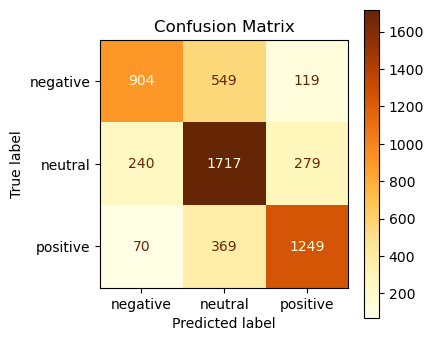

In [ ]:
xgb_model.fit(X_train_tfidf, y_train)
y_pred = xgb_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred,
                            target_names=['negative', 'neutral', 'positive']))

fig, ax = plt.subplots(figsize=(4, 4))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(ax=ax, cmap='YlOrBr')
plt.title("Confusion Matrix")
plt.show()

- In the case of using `TF-IDF`, we obtain a lower weighted f1-score weighter (0.6884 vs. 0.7025).
- However, the weighted precision was lower only for the negative class, and the recall was lower only for the positive class.

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [ ]:
test_df = pd.DataFrame(
    np.c_[raw_df.loc[test_idx, ['text', 'sentiment']], label_enc.inverse_transform(y_pred)],
    columns=['text', 'true_sentiment', 'predict_sentiment']
)

test_df.head()

,text,true_sentiment,predict_sentiment
0,Enjoy! Family trumps everything,positive,positive
1,--of them kinda turns me off of it all. And ...,negative,neutral
2,Clive it`s my birthday pat me http://apps.fac...,neutral,neutral
3,congrats hey,positive,positive
4,is texting,neutral,neutral


In [ ]:
error_df = test_df[test_df['true_sentiment'] != test_df['predict_sentiment']]
error_df.sample(7)

,text,true_sentiment,predict_sentiment
5460,I totally needed that sleep. need to stretch ...,neutral,negative
4944,i wish i could but it would cost too much to ...,negative,neutral
539,"Heh, aye. I should have investigated properly...",negative,neutral
1260,has toothache,negative,neutral
5350,", Decaf? I can do some teas late but never cof...",positive,neutral
4885,Thanks for the follow my new Twitpeeps!,negative,positive
5000,WOW i just drank a drink of water - 12 ice cub...,negative,neutral


In [ ]:
error_df[['true_sentiment', 'predict_sentiment']].value_counts()

true_sentiment  predict_sentiment
negative        neutral              549
positive        neutral              369
neutral         positive             279
                negative             240
negative        positive             119
positive        negative              70
Name: count, dtype: int64

In [ ]:
error_df.loc[:, 'tokenize_text'] = (
    error_df['text']
    .apply(tokenize)
    .map(lambda x: ' '.join(x if x not in english_stopwords else x)))
error_df.head()

C:\Users\Scar\AppData\Local\Temp\ipykernel_2412\2421747637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  error_df.loc[:, 'tokenize_text'] = (


,text,true_sentiment,predict_sentiment,tokenize_text
1,--of them kinda turns me off of it all. And ...,negative,neutral,"-- kinda turn . buy dig deeper hole , etc . ; ;"
8,OHSHNAPSSS. is she pissed at blair as usual ?...,neutral,negative,ohshnapsss . piss blair usual ? hahah . & yeee...
13,Doing really well! I will stay here as long a...,positive,neutral,realli well ! stay long need ! definit come vi...
17,At work... What a miserable day,negative,neutral,work ... miser day
21,I wish I had company,negative,positive,wish compani


In [ ]:
'miser' in vectorizer.vocabulary_.keys()

False

In [ ]:
'well' in vectorizer.vocabulary_.keys()

False

In [ ]:
error_df.sample(10)

,text,true_sentiment,predict_sentiment,tokenize_text
4127,what a smashing show tonight! Love the Killer...,neutral,positive,"smash show tonight ! love killer ! wish , gut ..."
4039,"Omedetou!! That`s truly exciting, but expecte...",positive,negative,"omedetou ! ! ` truli excit , expect , news ! d..."
1732,Hahhaa okaay ily! Lmfao,positive,neutral,hahhaa okaay ili ! lmfao
1247,why thank you. Couldn`t resist it,neutral,positive,thank . ` resist
2714,I am very angry at this information Marcos!!!!!!,negative,neutral,angri inform marco ! ! ! ! ! !
5246,Wow no one loves me,negative,positive,wow one love
4944,i wish i could but it would cost too much to ...,negative,neutral,wish could would cost much call way uk
3958,Spent the entire morning in a meeting w/ a ven...,neutral,positive,"spent entir morn meet w/ vendor , boss happi w..."
676,"Hey girl! Yeah, my allergies kick in at the ...",negative,neutral,"hey girl ! yeah , allergi kick random time . h..."
4866,_boo jealous can you add `and I really wish n...,neutral,negative,_boo jealous add ` realli wish nicol .. know `...


In [ ]:
error_df.loc[3251, :]

text                 ï¿½anisalovesu me too. I am so so upset,especi...
true_sentiment                                                 neutral
predict_sentiment                                             negative
tokenize_text        ï¿½anisalovesu . upset , especi fear ` get jar...
Name: 3251, dtype: object

In [ ]:
print(error_df.loc[3251, 'text'])
error_df.loc[3251, 'tokenize_text']

ï¿½anisalovesu me too. I am so so upset,especially because i fear i won`t get a Jared hug tomorrow


'ï¿½anisalovesu . upset , especi fear ` get jare hug tomorrow'

In [ ]:
log_reg = LogisticRegression(max_iter=MAX_ITER, solver='sag', random_state=42)
log_reg.fit(X_train_tfidf, y_train)

eli5.show_prediction(log_reg, error_df.loc[3251, 'tokenize_text'],
                     vec=vectorizer,
                     target_names=['negative', 'neutral', 'positive'])

In same cases the misclassification is a relevant error because even people can mistakes in classifying of these text.

In other cases, important words that indicate sentiment may be missing from the created vocabulary. 

To improve the classification model, the following actions could be considered:
- Clean the text more carefully (e.g., remove symbols like "ï¿½").
- Add information about punctuation as separate features and remove punctuation from from tokens - this could help include more sentiment-related words in the vocabulary.
- Use not only individual words but also phrases (n-grams).

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model